In [1]:
import numpy as np
import mnist_reader
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd


# LDA

# 1. 讀取資料
x_train, y_train = mnist_reader.load_data('data/oracle', kind='train')
x_test, y_test = mnist_reader.load_data('data/oracle', kind='t10k')

# 攤平成向量
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

# LDA 可降至 n_classes - 1 維（這裡是 9）
lda_components = 9

# 執行 LDA
lda = LinearDiscriminantAnalysis(n_components=lda_components)
x_train_lda = lda.fit_transform(x_train, y_train)
x_test_lda = lda.transform(x_test)

The size of train set: 27222
The size of t10k set: 3000


c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Adjusted Rand Index (ARI): 0.2528


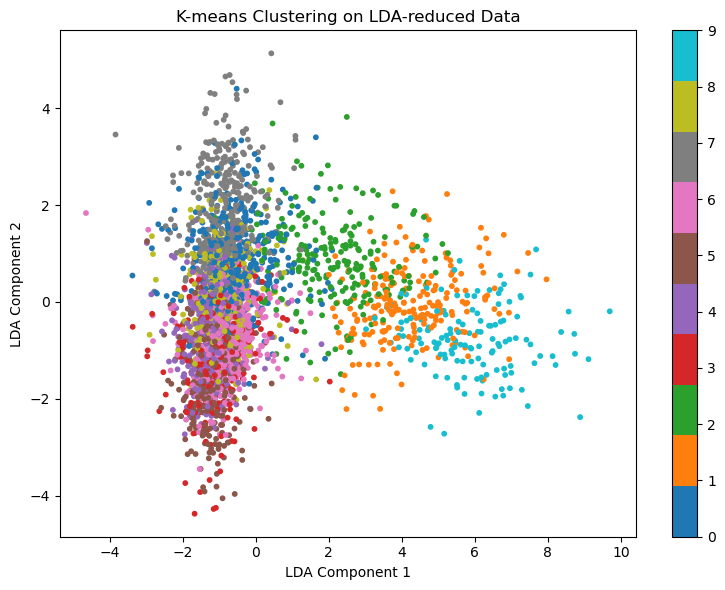

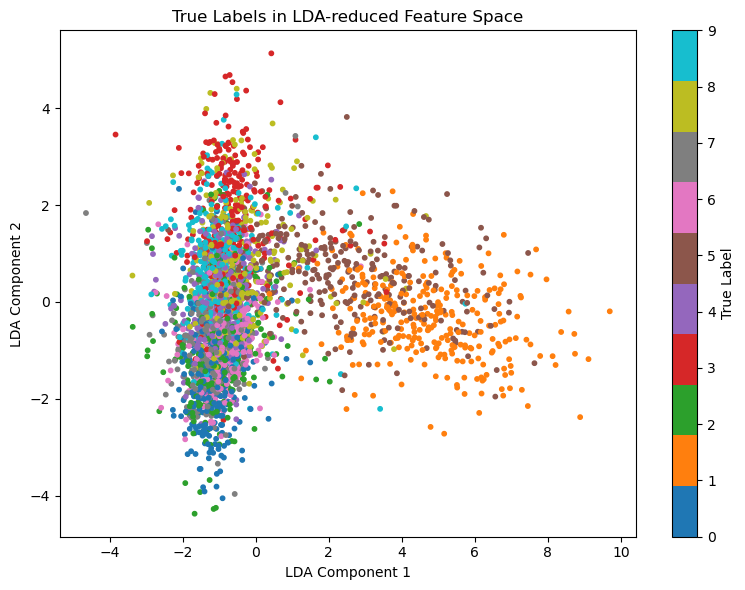

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# LDA + K-means clustering

# 設定群數（Oracle MNIST 是 10 類）
n_clusters = 10

# 建立 K-means 模型並訓練
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(x_test_lda)

# 評估 clustering 效果
ari = adjusted_rand_score(y_test, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# 繪製前兩個 LDA 特徵的 clustering 結果（只做 2D 可視化）
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_test_lda[:, 0], x_test_lda[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title("K-means Clustering on LDA-reduced Data")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.colorbar(scatter, ticks=range(n_clusters))
plt.tight_layout()
plt.savefig("lda_kmeans_clusters.png")
plt.show()

# 可視化：LDA 特徵空間中的真實類別（Ground Truth）
plt.figure(figsize=(8, 6))
scatter_gt = plt.scatter(x_test_lda[:, 0], x_test_lda[:, 1], c=y_test, cmap='tab10', s=10)
plt.title("True Labels in LDA-reduced Feature Space")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.colorbar(scatter_gt, ticks=range(10), label='True Label')
plt.tight_layout()
plt.savefig("lda_true_labels.png")
plt.show()



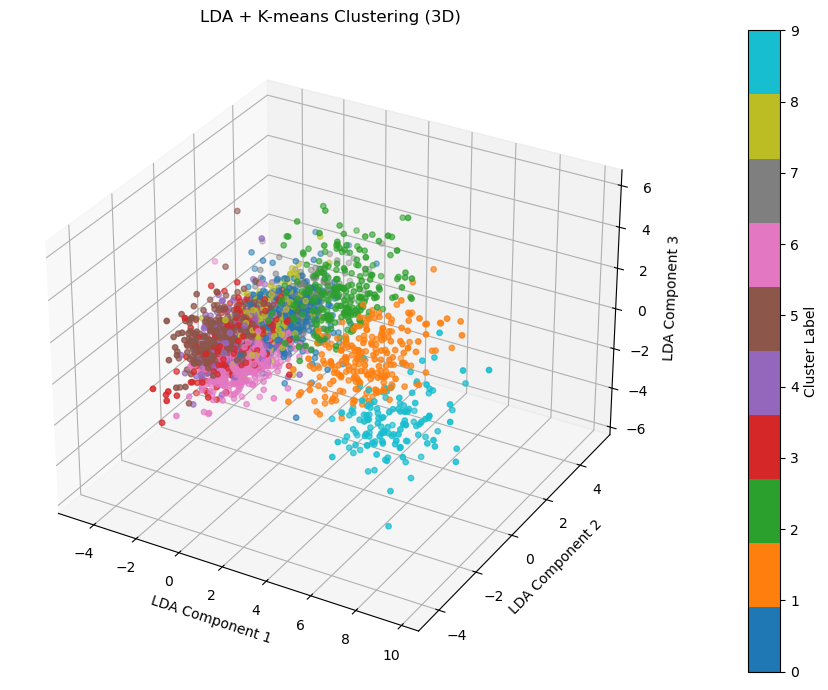

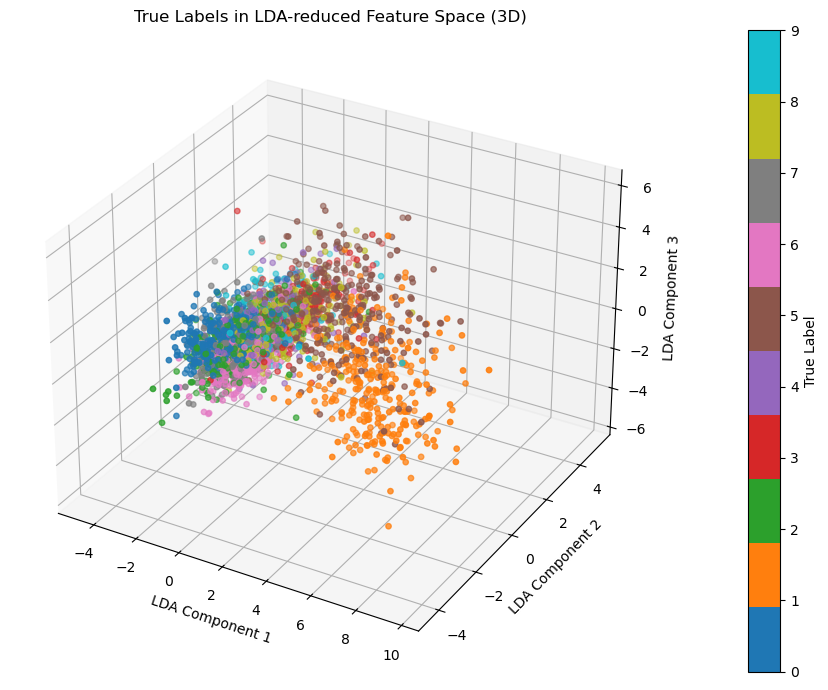

In [3]:
from mpl_toolkits.mplot3d import Axes3D  # 3D 畫圖工具

# LDA 可降到最多 9 維（classes - 1），這裡我們改成 3 維
lda_components = 3
lda = LinearDiscriminantAnalysis(n_components=lda_components)
x_train_lda = lda.fit_transform(x_train, y_train)
x_test_lda = lda.transform(x_test)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_test_lda[:, 0], x_test_lda[:, 1], x_test_lda[:, 2],
                     c=cluster_labels, cmap='tab10', s=15)
ax.set_title("LDA + K-means Clustering (3D)")
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_zlabel("LDA Component 3")
fig.colorbar(scatter, ax=ax, pad=0.1, ticks=range(n_clusters), label="Cluster Label")
plt.tight_layout()
plt.savefig("lda_kmeans_clusters_3d.png")
plt.show()
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter_gt = ax.scatter(x_test_lda[:, 0], x_test_lda[:, 1], x_test_lda[:, 2],
                        c=y_test, cmap='tab10', s=15)
ax.set_title("True Labels in LDA-reduced Feature Space (3D)")
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_zlabel("LDA Component 3")
fig.colorbar(scatter_gt, ax=ax, pad=0.1, ticks=range(10), label="True Label")
plt.tight_layout()
plt.savefig("lda_true_labels_3d.png")
plt.show()


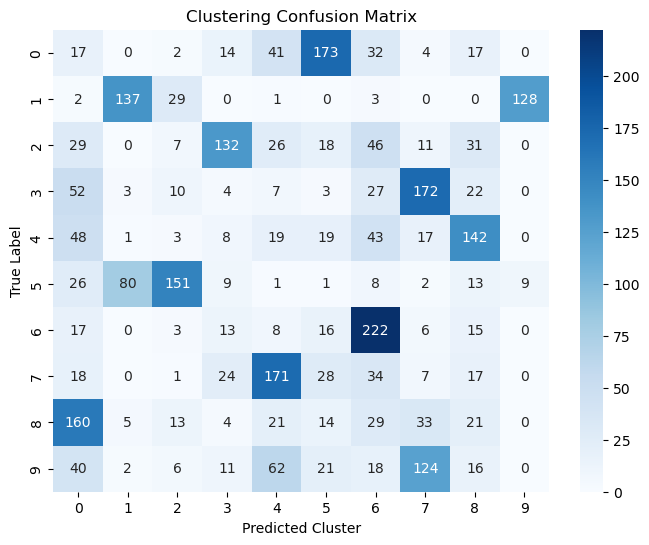

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 建混淆矩陣（預測 cluster vs 真實 label）
cm = confusion_matrix(y_test, cluster_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.title("Clustering Confusion Matrix")
plt.show()


c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


EM Clustering ARI: 0.1861


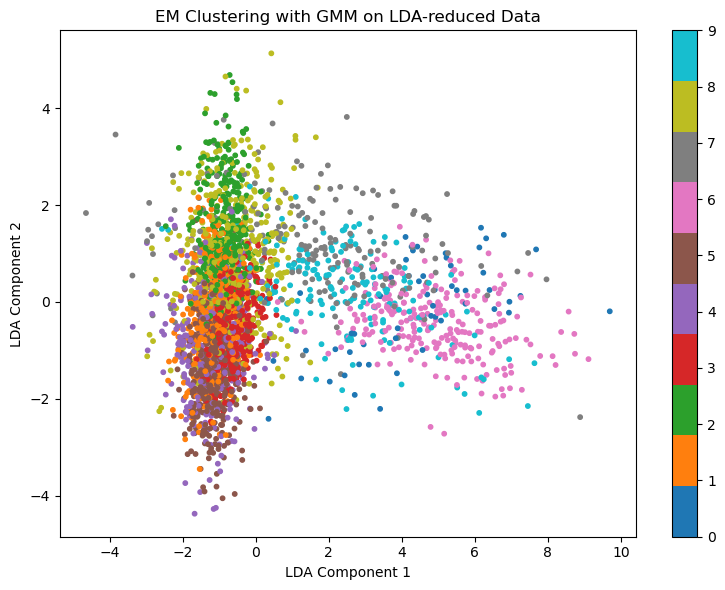

In [3]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

# LDA + EM algorithm

# 設定群數（仍為 10）
n_components = 10

# 建立 GMM 模型
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(x_test_lda)  # 只用 test 資料進行 unsupervised clustering

# 分群預測（返回最可能的群編號）
cluster_labels = gmm.predict(x_test_lda)

# 計算 Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y_test, cluster_labels)
print(f"EM Clustering ARI: {ari:.4f}")
# 繪製 clustering 結果
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_test_lda[:, 0], x_test_lda[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title("EM Clustering with GMM on LDA-reduced Data")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.colorbar(scatter, ticks=range(n_components))
plt.tight_layout()
plt.savefig("lda_em_clusters.png")
plt.show()
